# Tutorial:
## Sensitivity Analysis (SA) to discover factors shaping consequential dynamics
This notebook demonstrates the application of sensitivity analysis to
discover factors that shape the behavior modes of a socio-ecological system
with dynamic human action.

The model represents a system of prey and predator fish, with a human
actor harvesting the prey fish. The system is simple but very rich in
the dynamic behaviors it exhibits. You can read more about this system
at [Hadjimichael et al. (2020)](https://doi.org/10.1155/2020/4170453).

<img src="./figs/eqn2.png" width="300">

This complexity is accompanied by the presence of several equilibria that
come in and out of existence with different parameter values. The equilibria
also change in their stability according to different parameter values,
giving rise to different behavior modes.

<img src="./figs/Figure_1.png" width="600">

In the unharvested system (without the human actor) the stability of
several of these equilibria can be derived analytically. The task becomes
significantly more difficult when the adaptive human actor is introduced,
deciding to harvest the system at different rates according to their objectives and preferences.

Sensitivity analysis methods can help us identify the factors that most
control these dynamics by exploring the space of parameter values and
seeing how system outputs change as a result.

Through previously conducted optimization, there already exists a set of potential
harvesting strategies that were identified in pursuit of five objectives:

- Maximize Harvesting Discounted Profits (Net Present Value)
- Minimize Prey Population Deficit
- Minimize Longest Duration of Consecutive Low Harvest
- Maximize Worst Harvest Instance
- Minimize Harvest Variance

The identified harvesting strategies also meet the necessary constraint of not causing inadvertent predator collapse. 

We will be examining the effects of parametric uncertainty on these identified
strategies, particularly focusing on two
strategies, one selected to maximize harvesting profits and one identified through
previous analysis to perform 'well enough' for all objectives across a wide range
of states of the world (referred to as the 'robust' harvesting policy). 

In [1]:
from msdbook import fish_game

from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import patheffects as pe

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


## Step 1:  Load identified solutions and explore performance
Identify most robust and profit-maximizing solutions

In [ ]:
robustness = np.loadtxt('./data/Robustness.txt',delimiter=' ')
results = np.loadtxt('./data/solutions.resultfile')

robust_solution = np.argmax(robustness[:,-1]) #pick robust solution
profit_solution = np.argmin(results[:,6]) #pick profitable solution
objective_performance = -results[:,6:]

# Get decision variables for each of the policies
highprofitpolicy = results[profit_solution,0:6]
mostrobustpolicy = results[robust_solution,0:6]

Plot the identified solutions with regards to their objective performance.

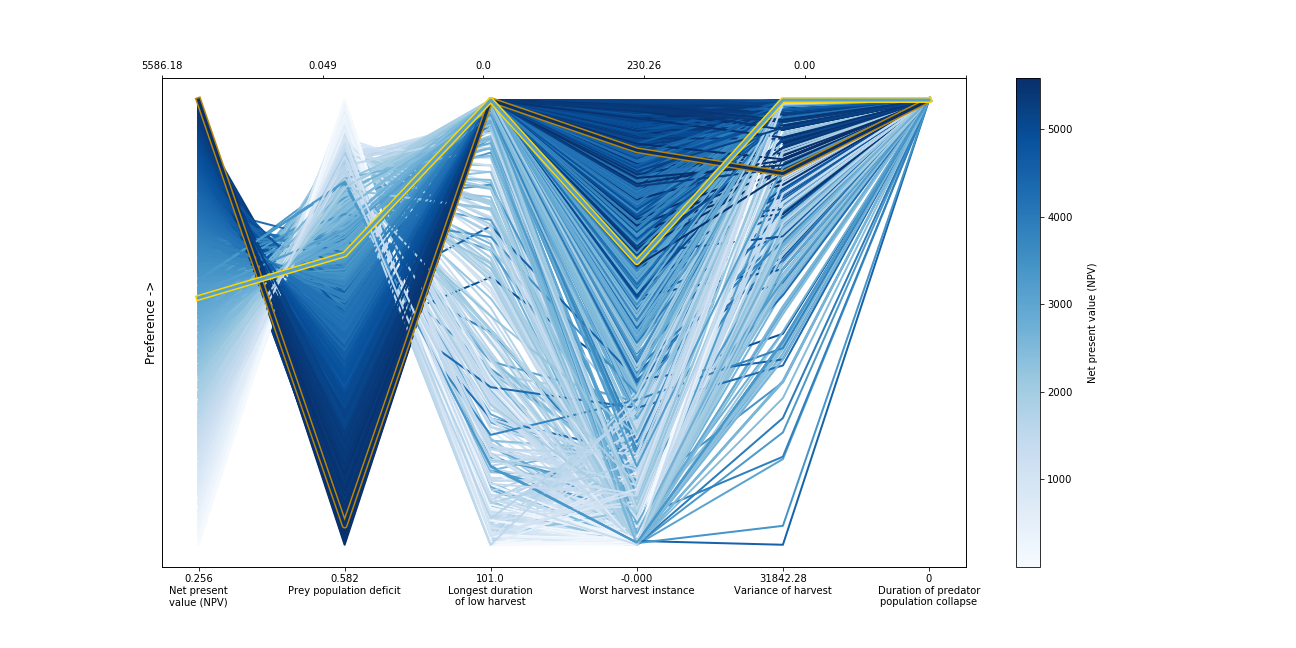

In [ ]:
fig = plt.figure(figsize=(18,9)) # create the figure
ax = fig.add_subplot(1, 1, 1)    # make axes to plot on

objs_labels = ['Net present\nvalue (NPV)', 
               'Prey population deficit', 
               'Longest duration\nof low harvest', 
               'Worst harvest instance',
               'Variance of harvest',
               'Duration of predator\npopulation collapse'] # Constraint (always 0)

# Normalization across objectives
mins = objective_performance.min(axis=0)
maxs = objective_performance.max(axis=0)
norm_reference = objective_performance.copy()
for i in range(5):
    mm = objective_performance[:,i].min()
    mx = objective_performance[:,i].max()
    if mm!=mx:
        norm_reference[:,i] = (objective_performance[:,i] - mm) / (mx - mm)
    else:
        norm_reference[:,i] = 1

cmap = plt.cm.get_cmap("Blues")

## Plot all solutions
for i in range(len(norm_reference[:,0])):
    ys = np.append(norm_reference[i,:], 1.0)
    xs = range(len(ys))
    ax.plot(xs, ys, c=cmap(ys[0]), linewidth=2)
    
'''
To highlight robust solutions
'''
ys = np.append(norm_reference[profit_solution,:], 1.0)# Most profitable
xs = range(len(ys))
l1=ax.plot(xs[0:6], ys[0:6], c=cmap(ys[0]), linewidth=3, label='Most robust in NPV', path_effects=[pe.Stroke(linewidth=6, foreground='darkgoldenrod'), pe.Normal()])
ys = np.append(norm_reference[robust_solution,:], 1.0) # Most robust in all criteria
xs = range(len(ys))
l2=ax.plot(xs[0:6], ys[0:6], c=cmap(ys[0]), linewidth=3, label='Most robust across criteria', path_effects=[pe.Stroke(linewidth=6, foreground='gold'), pe.Normal()])

#Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([objective_performance[:,0].min(),objective_performance[:,0].max()])
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel("\nNet present value (NPV)")

# Tick values
minvalues = ["{0:.3f}".format(mins[0]), "{0:.3f}".format(-mins[1]), 
             str(-mins[2]), "{0:.3f}".format(-mins[3]), "{0:.2f}".format(-mins[4]), str(0)]
maxvalues = ["{0:.2f}".format(maxs[0]), "{0:.3f}".format(-maxs[1]), 
             str(-maxs[2]), "{0:.2f}".format(maxs[3]), "{0:.2f}".format(-maxs[4]), str(0) ]

ax.set_ylabel("Preference ->", size= 12)
ax.set_yticks([])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([minvalues[i]+'\n'+objs_labels[i] for i in range(len(objs_labels))])
#make a twin axis for toplabels
ax1 = ax.twiny()
ax1.set_yticks([])
ax1.set_xticks([0,1,2,3,4,5])
ax1.set_xticklabels([maxvalues[i] for i in range(len(maxs))])
plt.savefig('Objectives_parallel_axis.png')

## Step 2: Use SALib to generate a sample for a Sobol sensitivity analysis
To do so, we first need to define the problem dictionary

In [ ]:
# Set up SALib problem
problem = {
  'num_vars': 9,
  'names': ['a', 'b', 'c', 'd', 'h', 'K', 'm', 'sigmaX', 'sigmaY'],
  'bounds': [[0.002, 2], [0.005, 1], [0.2, 1], [0.05, 0.2], [0.001, 1],
             [100, 5000], [0.1, 1.5], [0.001, 0.01], [0.001, 0.01]]
}
# Generate samples
param_values = saltelli.sample(problem, 1000, calc_second_order=False)

In [ ]:
'''Save or load generated sample for future reference'''
#np.savetxt("param_values.csv", param_values, delimiter=",")
param_values=np.loadtxt("./data/param_values.csv", delimiter=",")

## Step 3: Evaluate the system over all generated states of the world
We need to dentify the states where the predator population collapses,
as an inadvertent consequence of applying the harvesting strategy under
a state of the world different from the one originally assumed.

In [ ]:
# Create array to store collapse values under both policies
collapse_days = np.zeros([len(param_values), 2])
#Evaluate performance under every state
for i in range(len(param_values)):
    additional_inputs = np.append(['Previous_Prey'],
                                  [param_values[i,0],
                                   param_values[i,1],
                                   param_values[i,2],
                                   param_values[i,3],
                                   param_values[i,4],
                                   param_values[i,5],
                                   param_values[i,6],
                                   param_values[i,7],
                                   param_values[i,8]])
    collapse_days[i,0]=fish_game(highprofitpolicy, additional_inputs)[1][0]
    collapse_days[i,1]=fish_game(mostrobustpolicy, additional_inputs)[1][0]

In [ ]:
'''Save generated sample for future reference'''
#np.savetxt("./data/collapse_days.csv", collapse_days, delimiter=",")
collapse_days=np.loadtxt("./data/collapse_days.csv", delimiter=",")

## Step 4: Calculate sensitivity indices

In [ ]:
Si_profit = sobol.analyze(problem, collapse_days[:,0], calc_second_order=False, conf_level=0.95, print_to_console=True)
Si_robustness = sobol.analyze(problem, collapse_days[:,1], calc_second_order=False, conf_level=0.95, print_to_console=True)

In [ ]:
# Store values for future reference
f = open("./data/Si_robustness.txt","w")
f.write( str(Si_robustness) )
f.close()

f = open("./data/Si_profit.txt","w")
f.write( str(Si_profit) )
f.close()

Looking at the total-order indices (ST) we obtain, factors m, a, b, d
and K appear to affect the stability of this system. Looking at the first-order
indices (S1), we also see that besides factors m and a, all other factors are
important in this system through their interactions, which make up the
difference between their S1 and ST indices. This is another point evidence
against limiting sensitivity analyses to first order effects, as factor
importance might be significantly misjudged.

These findings are supported by the analytical condition of equilibrium
stability in this system:

<img src="./figs/eqn4.png">

In an unharvested system, this condition is both necessary and sufficient for the equilibrium of the two species coexisting to be stable. 

When adaptive human action is introduced however, this condition is still necessary, but no longer sufficient, as harvesting reduces the numbers of prey
fish and as a result reduces the resources for the predator fish.
Since this harvesting value is not constant, but can dynamically
adapt according to the harvester's objectives, it cannot be
introduced into this simple equation.

## Step 5: Explore relationship between uncertain factors and performance
In the following steps, we will use the results of our sensitivity analysis to investigate the relationships between 
parametric uncertainty, equilibrium stability and the performance of the two policies.

We can use the top three factors identified (m, a, and b) to visualize the performance of our policies in this three-dimensional parametric space. 

We first define the stability condition, as a function of b and m, and calculate the corresponding values of a. We can  

In [ ]:
def inequality(b,m,h,K):
    return ((b**m)/(h*K)**(1-m))

b= np.linspace(start=0.005, stop=1, num=1000)
m= np.linspace(start=0.1, stop=1.5, num=1000)
h= np.linspace(start=0.001, stop=1, num=1000)
K= np.linspace(start=100, stop=2000, num=1000)
b, m = np.meshgrid(b, m)
a = inequality(b,m,h,K)
a = a.clip(0,2)

In [ ]:
cmap = plt.cm.get_cmap("RdBu_r")

fig = plt.figure(figsize=plt.figaspect(0.5), dpi=600, constrained_layout=True)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sows = ax1.scatter(param_values[:,1], param_values[:,6], param_values[:,0], c=collapse_days[:,0], cmap=cmap, s=0.5)
pts_ineq = ax1.plot_surface(b, m, a, color='black', alpha=0.25, zorder=1)
pt_ref = ax1.scatter(0.5,0.7,0.005, c='black', s=50, zorder=0)
sm = plt.cm.ScalarMappable(cmap=cmap)
ax1.set_xlabel("b")
ax1.set_ylabel("m")
ax1.set_zlabel("a")
ax1.set_zlim([0.0,2.0])
ax1.set_xlim([0.0,1.0])
ax1.set_ylim([0.0,1.5])
ax1.xaxis.set_view_interval(0,  0.5)
ax1.set_facecolor('white')
ax1.view_init(12, -17)
ax1.set_title('Profit maximizing policy')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sows = ax2.scatter(param_values[:,1], param_values[:,6], param_values[:,0], c=collapse_days[:,1], cmap=cmap, s=0.5)
pts_ineq = ax2.plot_surface(b, m, a, color='black', alpha=0.25, zorder=1)
pt_ref = ax2.scatter(0.5,0.7,0.005, c='black', s=50, zorder=0)
sm = plt.cm.ScalarMappable(cmap=cmap)
ax2.set_xlabel("b")
ax2.set_ylabel("m")
ax2.set_zlabel("a")
ax2.set_zlim([0.0,2.0])
ax2.set_xlim([0.0,1.0])
ax2.set_ylim([0.0,1.5])
ax2.xaxis.set_view_interval(0,  0.5)
ax2.set_facecolor('white')
ax2.view_init(12, -17)
ax2.set_title('Robust policy')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([collapse_days.min(), collapse_days.max()])
cbar = fig.colorbar(sm)
cbar.set_label('Days with predator collapse')

These figures indicate several things.

First, that as asserted above, the policies interact with the system in different and complex ways. In the presence of human action the stability condition is not sufficient in determining whether the policy will succeed, even though it clearly shapes the system in a fundamental manner. 

Secondly, the robust policy manages to avoid collapse in many more of the sampled states of the world, indicated by the number of blue points. This presents a clear tradeoff between profit-maximizing performance and robustness against uncertainty.
